In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Sentiment analysis, also known as opinion mining, is a technique used in natural language processing (NLP) to identify and extract subjective information from text data. Its main objective is to determine the polarity of sentiments expressed in a given text, whether they are positive, negative, or neutral.

Businesses can leverage sentiment analysis to analyze customer feedback, product reviews, social media posts, and other types of text data to gain insights into the attitudes, opinions, and emotions of individuals towards their products, services, or brand. By identifying areas for improvement and highlighting areas of strength, sentiment analysis helps businesses make data-driven decisions, enhance customer satisfaction, and improve brand reputation.

To perform sentiment analysis, various techniques such as rule-based systems, machine learning algorithms, and deep learning models can be used. The choice of technique depends on the complexity of the text data and the specific use case. In recent years, machine learning-based approaches have become more popular due to their ability to handle large volumes of text data and achieve high accuracy in sentiment classification.

Overall, sentiment analysis is a powerful tool that helps businesses gain valuable insights into customer feedback and opinions. By utilizing these insights, businesses can make informed decisions and take actions that lead to better customer experiences and overall success.

In [58]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


import string
import re
import nltk

In [3]:
train = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv')
test = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv')
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Data Preprocessing

In [38]:
train['tweet'] = train['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()

In [40]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [42]:
#remove all stopwords
SW = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in SW])
train['tweet'] =train['tweet'].apply(lambda text: cleaning_stopwords(text))

In [47]:
#remove ponctuation
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
train['tweet'] =train['tweet'].apply(lambda x: cleaning_punctuations(x))

In [56]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
train['tweet'] =train['tweet'].apply(lambda x: cleaning_repeating_char(x))

In [54]:
#Remove URLs
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
train['tweet'] =train['tweet'].apply(lambda x: cleaning_URLs(x))

In [55]:
#Remove numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
train['tweet'] =train['tweet'].apply(lambda x: cleaning_numbers(x))

In [59]:
#stemming
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
train['tweet'] =train['tweet'].apply(lambda x: stemming_on_text(x))

In [5]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [4]:
print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


In [6]:
train.isnull().any()
test.isnull().any()

id       False
tweet    False
dtype: bool

0    29720
1     2242
Name: label, dtype: int64


<AxesSubplot: >

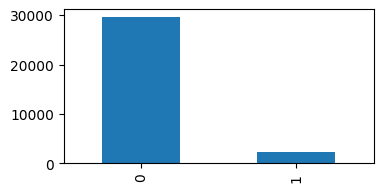

In [14]:
print(train['label'].value_counts())
train['label'].value_counts().plot.bar(figsize = (4,2))

In [17]:
train.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                    len                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0

Training data is highly imbbalance as we have only 2242 tweets with positive and 29720 with negative sentiments. Lets cehck out some off the tweets with negative and positive

In [9]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [10]:
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


adding a length column to thhe tweet

In [15]:
train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

train.head(10)

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39
5,6,0,[2/2] huge fan fare and big talking before the...,116
6,7,0,@user camping tomorrow @user @user @user @use...,74
7,8,0,the next school year is the year for exams.ð...,143
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,87
9,10,0,@user @user welcome here ! i'm it's so #gr...,50


<AxesSubplot: ylabel='Frequency'>

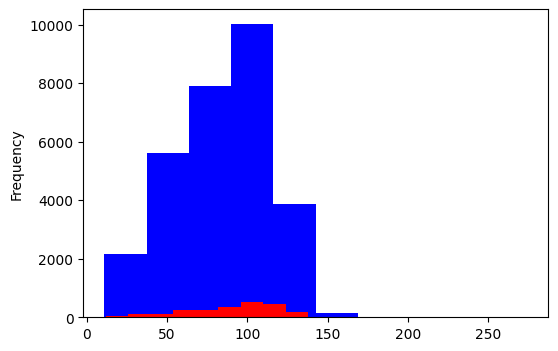

In [26]:
# length of negative and positive comment
len_pos = train[train['label'] == 1]
len_neg = train[train['label'] == 0]
len_neg['tweet'].str.len().plot.hist(color = 'blue', figsize = (6, 4))
len_pos['tweet'].str.len().plot.hist(color = 'red', figsize = (6, 4))

In [23]:
len_pos

,id,label,tweet,len
13,14,1,@user #cnn calls #michigan middle school 'buil...,74
14,15,1,no comment! in #australia #opkillingbay #se...,101
17,18,1,retweet if you agree!,22
23,24,1,@user @user lumpy says i am a . prove it lumpy.,47
34,35,1,it's unbelievable that in the 21st century we'...,104
...,...,...,...,...
31934,31935,1,lady banned from kentucky mall. @user #jcpenn...,59
31946,31947,1,@user omfg i'm offended! i'm a mailbox and i'...,82
31947,31948,1,@user @user you don't have the balls to hashta...,112
31948,31949,1,"makes you ask yourself, who am i? then am i a...",87


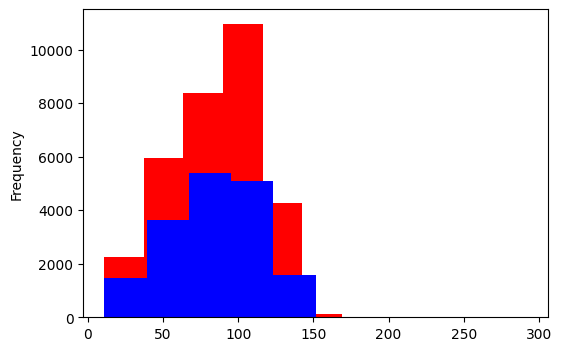

In [16]:
#checking the distribution of tweets in the data

length_train = train['tweet'].str.len().plot.hist(color = 'red', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'blue', figsize = (6, 4))

So the lengthh of tweets is very diffferent in test and training data

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

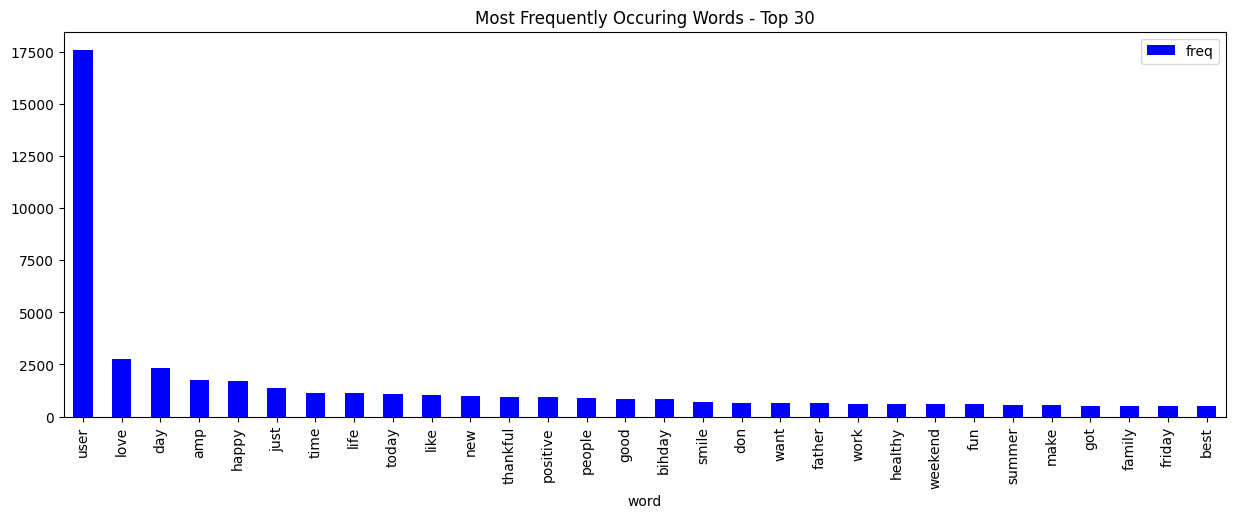

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 5), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'WordCloud - Vocabulary from Reviews')

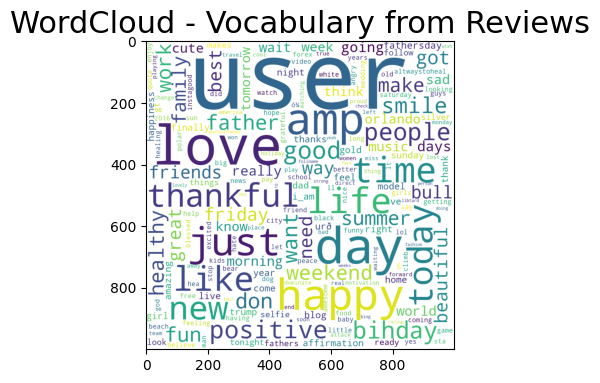

In [32]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(6,4))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

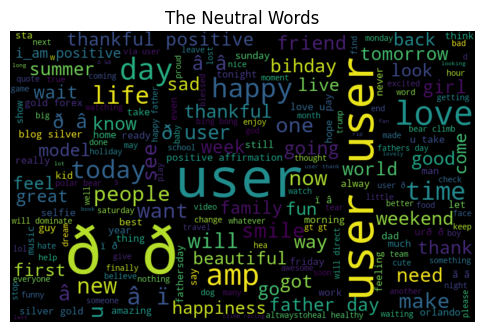

In [33]:
normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

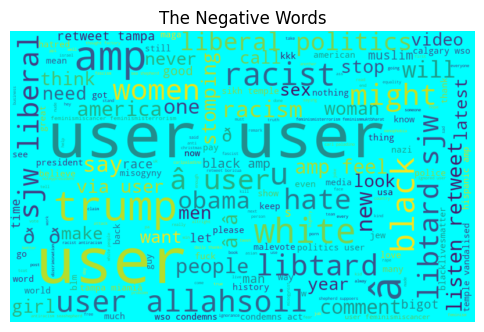

In [34]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(6, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()